# Food recipes generator

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import platform
import time

import pathlib
import os
import json
import zipfile

import emoji

### Load the data

In [2]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [3]:
dataset_file_path = 'datasets/recipes_raw.zip'

In [4]:
!ls -la ./tmp/datasets/

total 503896
drwxr-xr-x@ 8 CristaVillatoro  staff       256 Mar 24 09:04 .
drwxr-xr-x@ 5 CristaVillatoro  staff       160 Mar 28 14:11 ..
-rw-r--r--@ 1 CristaVillatoro  staff      6148 Mar 24 09:04 .DS_Store
drwx------@ 6 CristaVillatoro  staff       192 Mar 24 09:04 recipes_raw
-rw-r--r--@ 1 CristaVillatoro  staff  53355492 Mar 23 16:51 recipes_raw.zip
-rw-rw-r--@ 1 CristaVillatoro  staff  49784325 Mar 23  2018 recipes_raw_nosource_ar.json
-rw-rw-r--@ 1 CristaVillatoro  staff  61133971 Mar 23  2018 recipes_raw_nosource_epi.json
-rw-rw-r--@ 1 CristaVillatoro  staff  93702755 Mar 23  2018 recipes_raw_nosource_fn.json


In [5]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

In [6]:
dataset_raw = load_dataset() 

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [7]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


### Processing data

In [8]:
# Filters out recipes which don't have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [9]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalide recipes 2226


Converting recipes objects into strings

In [10]:
# Adding Landmarks
STOP_WORD_TITLE = emoji.emojize(':books:')
STOP_WORD_INGREDIENTS = emoji.emojize('\n:hot_pepper:\n\n')
STOP_WORD_INSTRUCTIONS = emoji.emojize('\n:cook:\n\n')

In [11]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [12]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [13]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📚Slow Cooker Chicken and Dumplings

🌶️

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

🧑‍🍳

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📚Awesome Slow Cooker Pot Roast

🌶️

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

🧑‍🍳

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Rec

In [14]:
print(dataset_stringified[66000])

📚Coconut Cupcakes

🌶️

• 3/4 pound (3 sticks) unsalted butter, room temperature
• 2 cups sugar
• 5 extra-large eggs at room temperature
• 1 1/2 teaspoons pure vanilla extract
• 1 1/2 teaspoons pure almond extract
• 3 cups flour
• 1 teaspoon baking powder
• 1/2 teaspoon baking soda
• 1/2 teaspoon kosher salt
• 1 cup buttermilk
• 14 ounces sweetened, shredded coconut
• 1 pound cream cheese at room temperature
• 3/4 pound (3 sticks) unsalted butter, room temperature
• 1 teaspoon pure vanilla extract
• 1/2 teaspoon pure almond extract
• 1 1/2 pounds confectioners' sugar, sifted

🧑‍🍳

▪︎ Watch how to make this recipe.
▪︎ Preheat the oven to 325 degrees F.
▪︎ In the bowl of an electric mixer fitted with the paddle attachment, cream the butter and sugar on high speed until light and fluffy, about 5 minutes. With the mixer on low speed, add the eggs, 1 at a time, scraping down the bowl after each addition. Add the vanilla and almond extracts and mix well.
▪︎ In a separate bowl, sift together t

### Removing large recipes

Recipes have different lengths. We need to have one hard-coded sequence length limit before feeding recipes sequences to RNN. We need to find out what recipe length will cover most of recipe use-cases and at the same time we want to keep it as small as possible for training performance.

In [15]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

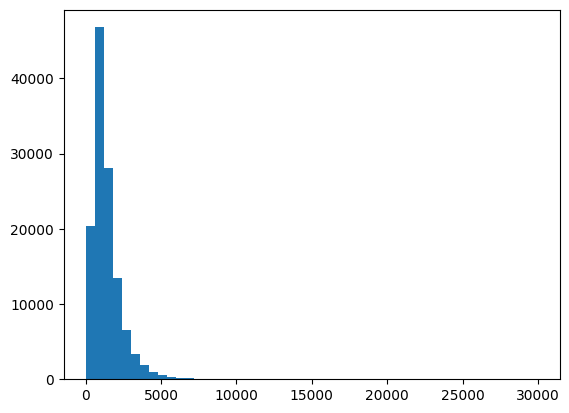

In [16]:
plt.hist(recipes_lengths, bins=50)
plt.show()

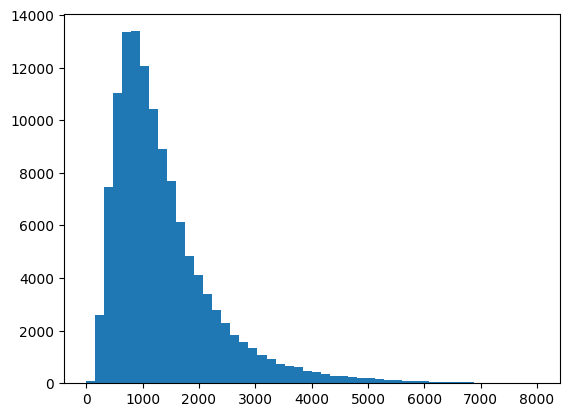

In [17]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [18]:
DEBUG = False
DEBUG_EXAMPLES = 10

In [19]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000

if DEBUG:
    MAX_RECIPE_LENGTH = 500

In [20]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [21]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100165
Number of etiminated recipes:  22773


In [22]:
if DEBUG:
    dataset_filtered = dataset_filtered[:DEBUG_EXAMPLES]
    print('dataset_filtered.shape, ', len(dataset_filtered))

Dataset parameters

In [23]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100165


### It is necessary to create a vocabulary
To create a vocabulary out of recipes texts we will use tf.keras.preprocessing.text.Tokenizer

In [24]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [26]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [27]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [28]:
tokenizer.fit_on_texts(dataset_filtered)

In [29]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100167,
 'word_counts': '{"\\u2423": 2, "\\ud83d\\udcda": 100165, "S": 270043, "l": 3811648, "o": 5981934, "w": 963541, " ": 17411716, "C": 222685, "k": 890217, "e": 9287386, "r": 4756439, "h": 2919095, "i": 4907166, "c": 2881036, "n": 5299526, "a": 6061689, "d": 3096821, "D": 63933, "u": 2714675, "m": 1792802, "p": 2676886, "g": 1697165, "s": 4699829, "\\n": 1954034, "\\ud83c\\udf36": 100165, "\\ufe0f": 100165, "\\u2022": 922146, "4": 232438, ",": 1129373, "b": 1393463, "t": 5991833, "v": 746048, "2": 493535, "(": 144881, "1": 853299, "0": 145015, ".": 1051629, "7": 31072, "5": 153961, ")": 144873, "f": 1041928, "y": 665879, "\\ud83e\\uddd1": 100165, "\\u200d": 100165, "\\ud83c\\udf73": 100165, "\\u25aa": 330807, "\\ufe0e": 330807, "P": 200442, "6": 51362, "H": 43902, "A": 134138, "3": 213368, "R": 101162, "x": 201160, "/": 345043, "I": 81544, "L": 46113, "8":

In [30]:
# Adding +1 to take into account a special unassigned 0 index.
#  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) +1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  179


In [31]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

o
,


In [32]:
tokenizer.word_index['r']

8

In [33]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', '📚', '🌶', '️', '🧑', '\u200d', '🍳', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '?', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'á', 'ó', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', 'à', '_', '\xad', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', '␣', 'Á', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


In [34]:
# Test proper conversion from text to indices.
# This is needed for debugging a demo app.
tokenizer.texts_to_sequences(['📚 yes'])

[[51, 1, 28, 2, 9]]

Vectorizing the dataset: Now, once we have a vocabulary (character --> code and code --> character relations) we may convert the set of recipes from text to numbers (RNN works with numbers as an input and not with the texts).

In [35]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [36]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [37]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100165


In [38]:
print(dataset_vectorized[0][:10], '...')

[51, 33, 10, 5, 23, 1, 35, 5, 5, 25] ...


In [39]:
recipe_sequence_to_string(dataset_vectorized[0])

📚Slow Cooker Chicken and Dumplings

🌶️

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

🧑‍🍳

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



### Add padding to sequences
We need all recipes to have the same length for training. To do that we'll use tf.keras.preprocessing.sequence.pad_sequences utility to add a stop word to the end of each recipe and to make them have the same length.

In [40]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 548
Recipe #2 length: 403
Recipe #3 length: 673
Recipe #4 length: 738
Recipe #5 length: 1520
Recipe #6 length: 742
Recipe #7 length: 841
Recipe #8 length: 669
Recipe #9 length: 1266
Recipe #10 length: 856


In [41]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [42]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [43]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [44]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📚Slow Cooker Chicken and Dumplings

🌶️

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

🧑‍🍳

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [45]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  178


### Create TensorFlow dataset

In [46]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


In [47]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51  33  10 ... 156 156 156] 



Stringified recipe:

📚Slow Cooker Chicken and Dumplings

🌶️

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

🧑‍🍳

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

### Split examples on input and target texts

For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is Hello. The input sequence would be Hell, and the target sequence ello.

In [48]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [49]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [50]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📚 S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🌶 ️ \n \n •   4   s k i n l e'
Target:  'S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🌶 ️ \n \n •   4   s k i n l e s'


2023-03-30 14:23:21.050989: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [51]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📚')
  expected output: 33 ('S')
Step  2
  input: 33 ('S')
  expected output: 10 ('l')
Step  3
  input: 10 ('l')
  expected output: 5 ('o')
Step  4
  input: 5 ('o')
  expected output: 23 ('w')
Step  5
  input: 23 ('w')
  expected output: 1 (' ')
Step  6
  input: 1 (' ')
  expected output: 35 ('C')
Step  7
  input: 35 ('C')
  expected output: 5 ('o')
Step  8
  input: 5 ('o')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 25 ('k')
Step 10
  input: 25 ('k')
  expected output: 2 ('e')


### Split up the dataset into batches

In [52]:
print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [53]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100165
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  179


In [54]:
# Batch size.
BATCH_SIZE = 64

if DEBUG:
    BATCH_SIZE = DEBUG_EXAMPLES

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

if DEBUG:
    SHUFFLE_BUFFER_SIZE = 1

In [55]:
if DEBUG:
    dataset_train = dataset_targeted \
        .repeat() \
        .batch(BATCH_SIZE, drop_remainder=True)
else:
    dataset_train = dataset_targeted \
      .shuffle(SHUFFLE_BUFFER_SIZE) \
      .batch(BATCH_SIZE, drop_remainder=True) \
      .repeat()

print(dataset_train)

<RepeatDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>


In [56]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51  33   4 ... 156 156 156]
 [ 51  44  15 ... 156 156 156]
 [ 51  61   2 ... 156 156 156]
 ...
 [ 51  70  27 ... 156 156 156]
 [ 51  33  14 ... 156 156 156]
 [ 51  48   5 ... 156 156 156]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 33   4   8 ... 156 156 156]
 [ 44  15  15 ... 156 156 156]
 [ 61   2   9 ... 156 156 156]
 ...
 [ 70  27   2 ... 156 156 156]
 [ 33  14  18 ... 156 156 156]
 [ 48   5  13 ... 156 156 156]], shape=(64, 2000), dtype=int32)


### Build the model
Use tf.keras.Sequential to define the model. For this experiment we will use the following layer types:

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
tf.keras.layers.LSTM: A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [57]:
from keras import backend as K
K.clear_session()
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 47ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[3 0 4 5 5 1 2 3]
 [2 4 9 9 9 1 8 7]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.01710508 -0.03903931 -0.01630295 -0.00221902  0.01532792]
  [-0.01941038  0.03382089  0.01233001  0.03651467 -0.04173885]
  [-0.00922685 -0.03777511  0.04515512  0.04975934  0.00715361]
  [-0.01551767 -0.04398663 -0.02159615 -0.03673499  0.01142035]
  [-0.01551767 -0.04398663 -0.02159615 -0.03673499  0.01142035]
  [-0.04856639  0.03576228 -0.0016999   0.03947054  0.02386943]
  [ 0.0447562  -0.04373555 -0.00634873  0.02282954  0.01250333]
  [-0.01710508 -0.03903931 -0.01630295 -0.00221902  0.01532792]]

 [[ 0.0447562  -0.04373555 -0.00634873  0.02282954  0.01250333]
  [-0.00922685 -0.03777511  0.04515512  0.04975934  0.00715361]
  [ 0.04437328 -0.03854138 -0.01519754  0.0481426   0.01836762]
  [ 0.04437328 -0.03854138 -0.01519754  0.0481426   0.01836762]
  [ 0.04437328 -0.03854138 -0.01519754 

Model

In [58]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [59]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    K.clear_session()
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [60]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           45824     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 179)           183475    
                                                                 
Total params: 5,476,275
Trainable params: 5,476,275
Non-trainable params: 0
_________________________________________________________________


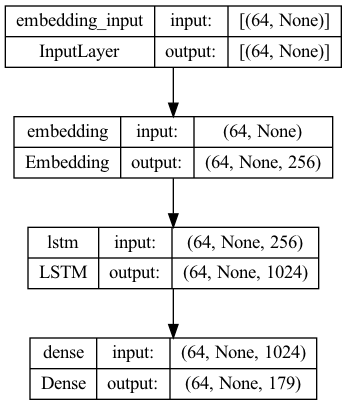

In [61]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

Trying the model

In [62]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 179) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [63]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 2.2256479e-03  2.9853085e-04 -2.1225060e-03  1.4233462e-03
  3.3880891e-03  1.9097853e-03  1.3771505e-03  2.9090943e-04
  3.5549500e-03  1.9999049e-03  1.3200555e-03 -8.1899198e-04
  5.2220798e-03 -4.1660895e-03  6.9634075e-04 -2.5433605e-03
 -7.2172610e-04  1.4085525e-03  2.9023509e-03 -7.9121580e-04
 -2.4242012e-03  3.9523384e-03  3.5283514e-03 -2.9997998e-03
 -4.6986178e-03  1.6747213e-03  1.1991487e-03 -1.0783018e-03
 -3.4629565e-03  2.3966969e-03 -1.4907686e-03 -4.4431458e-03
  5.3265848e-04  1.4132492e-03  5.4454748e-03 -4.3943236e-03
  1.1433200e-03 -2.4167991e-04 -4.4291574e-03  3.2832951e-03
  2.1516886e-03 -2.6904477e-03 -2.0090439e-03  2.1700042e-03
  1.0762336e-03 -5.2644154e-03 -4.4988338e-03  6.8928432e-03
 -5.4806349e-04 -2.3560152e-04  1.3432323e-03 -4.8772604e-03
 -1.8176354e-03  6.9145141e-03  5.7911165e-03 -3.7367125e-03
  1.4059152e-03 -4.9876729e-03  3.2437434e-03  1.2097432e-03
 -4.2908317e-03 -

In [64]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 1 1 2]], shape=(1, 5), dtype=int64)


In [65]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [66]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [67]:
sampled_indices[:100]

array([133, 168, 157,   1,  81,  88, 150,  40, 119, 110,  84,  13,  53,
       152,  15,  57,  97,  41,  69,  64, 153,  61, 151, 130,  22, 175,
        73, 106, 109, 130, 107, 135,  24,  86,  74, 132,  37,  25,  34,
       140,  80, 162,   3,  46,  87, 163,  83, 175, 175, 106, 140, 144,
       129, 116, 105, 139,  50, 158,  56, 163,  21, 138, 165,  53,  67,
       107,  60,  34, 126,  41, 169,  92, 160,  42,  94, 107,  76, 116,
         0, 112, 141, 170,  79, 143,  96, 159,  23, 124,  23,  65, 125,
        20,  88,  64,  97, 165,  38,  90, 163, 147])

In [68]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📚 S a u t e e d   A p p l e s \n \n 🌶 ️ \n \n •   1 / 4   c u p   b u t t e r   \n •   4   l a r g e   t'

Next char prediction:
 '́ Â Á   é – ‧ 5 [ $ Q c ️ ⅛ p I ¿ 0 7 G å D \u202d ä f ⅞ K © > ä ¼ ö • ! 9 ù 3 k 4 ” ° ⅓ a z Z | Y ⅞ ⅞ ©'


Trying the model with variable input

In [69]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 179) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

Training the model
Attach an optimizer, and a loss function

In [70]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 179)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.1769958


In [71]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Configuring checkpoints

In [72]:
!rm -rf './tmp/checkpoints'

In [73]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [74]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [75]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [76]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [77]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

Configuring callbacks

In [78]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [79]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

The training execution was made on a notebook using Kaggle due to the GPU availability

In [80]:
simplified_batch_size = 1
model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
model_1_simplified.load_weights('recipe_generation_rnn.h5')

In [81]:
model_1_simplified.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, None, 256)            45824     
                                                                 
 lstm (LSTM)                 (1, None, 1024)           5246976   
                                                                 
 dense (Dense)               (1, None, 179)            183475    
                                                                 
Total params: 5,476,275
Trainable params: 5,476,275
Non-trainable params: 0
_________________________________________________________________


In [82]:
model_1_simplified.input_shape

(1, None)

In [83]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [94]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'Mushroom', 'The', 'Sauce', 'Spinach']
    try_temperature = [1.0, 0.8]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [95]:
generate_combinations(model_1_simplified)

Attempt: "" + 1.0
-----------------------------------
📚PRITATES Ginger Chex Mamained Onion Meatballes

🌶️

• 1 cup mayonnaise
• 1/2 cup vegetable broth
• 2 onions, finely chopped (7 to 8 ounces)
• Sea salt, steamy preferred blend, recipe follows
• 4 eggs, beaten
• 1 tsp. brown sugar
• 1/2 tsp garlic powder
• 1 mixed chicory, sheets trimmed, such as cremini, frisee, ends and guest underchipe uses.
• 24 grams sweet pancakes
• 2/3 cup shredded asiago, softened butter cheese
• 6 eggs
• 10 cloves garlic
• 1/3 cup all-purpose flour

🧑‍🍳

▪︎ Preheat oven to 450 degrees F.
▪︎ Scrape slabs off of the marinade. Place a large plastic wrap over juice and fennel mixture. Combine the turkey with a fried egg whites, seeded remaining chicken breasts, more brown sugar and vinegar. Spread to dishes about 1-inch from the bottom of the middle. Coat a flour or cookie sheet with butter; mix well. Rub this dust spray in extra 1ge. Place under broiler for 2 to 3 minutes over moderate heat 20 to 35 minutes ove

### Load model

In [100]:
model = keras.models.load_model('recipe_generation_rnn.h5')

In [101]:
model.compile()

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, None, 256)            45824     
                                                                 
 lstm (LSTM)                 (1, None, 1024)           5246976   
                                                                 
 dense (Dense)               (1, None, 179)            183475    
                                                                 
Total params: 5,476,275
Trainable params: 5,476,275
Non-trainable params: 0
_________________________________________________________________


In [103]:
generate_combinations(model)

Attempt: "" + 1.0
-----------------------------------
📚50d me long match.
▪︎ Meanwhile, make the tart bought; reserve heavy cream. Top with remaining whites and whipped cream.
▪︎ Arrange remaining ingredients in cups, cut or mound on each sheet pan. Spoon mixture back into the bag, preferably overhanging bowl. Sprinkle with minced chile sauce, cover with foil, and set pan while both stand to pan-idea. The better!
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣